In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/stageactia/siren detection/pitch.ipynb

cp: -r not specified; omitting directory '/content/drive/MyDrive/stageactia/siren'


Importing the libraries


In [ ]:
import os
import glob
import time
import librosa
import librosa.display
import scipy
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker


class Pitch_Detect:

    def __init__(self, y, sr, Ws): 

        self.y = y
        self.sr = sr
        self.N = Ws


    def hpf(self, filter_stop_freq=50, filter_pass_freq=200, filter_order=1001):

        nyquist_rate = self.sr / 2.
        desired = (0, 0, 1, 1)
        bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
        filter_coefs = scipy.signal.firls(filter_order, bands, desired, nyq=nyquist_rate)
        
        filtered_audio = scipy.signal.filtfilt(filter_coefs, [1], self.y)
        return filtered_audio


    def camdf(self, y_clip, tau):
        D = 0.0
        for n in range(self.N):
            D += abs(y_clip[(n + tau)%self.N] - y_clip[n])
        return D


    def pitch_curve(self):
        l = self.N
        N = len(self.y[:l+1])
        pitch_list = []
        ran = (len(self.y)//(l//2))-2
        
        for i in range(ran):
            camdf_list = []
            y_clip = self.y[(l//2)*i:(l//2)*i+l+1]
            for i in range(l):
                camdf_list.append(self.camdf(y_clip=y_clip, tau=i))
            interval = camdf_list[4:100]
            min_D = min(interval)
            pitch_detected = round(self.sr/(interval.index(min_D)+4),2)
            pitch_list.append(pitch_detected)
        
        return pitch_list, ran

    def plot_figure(self, pitch_list, ran):
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(111)
        ax.plot(pitch_list)
        scale_x = ran/10.0
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
        ax.xaxis.set_major_formatter(ticks_x)
        ax.set_xlabel("time (s)")
        ax.set_ylabel('Pitch (hz)')
        plt.grid('on')
        plt.tight_layout()
        plt.show()


In [ ]:
import os
import glob
import time

import numpy as np
#IPython.display for audio output
import IPython.display as ipd
# Librosa for audio
import librosa
import librosa.display

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
file = '/content/drive/MyDrive/cleaned_data/eval_balanced/Emergency/109.wav'
y, sr = librosa.load(file, sr=8000)
ipd.Audio(file)

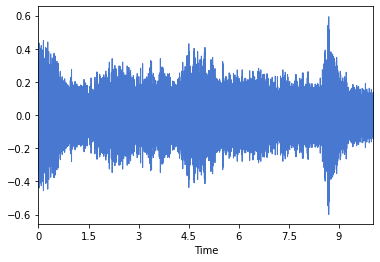

In [ ]:
librosa.display.waveplot(y=y, sr=sr)

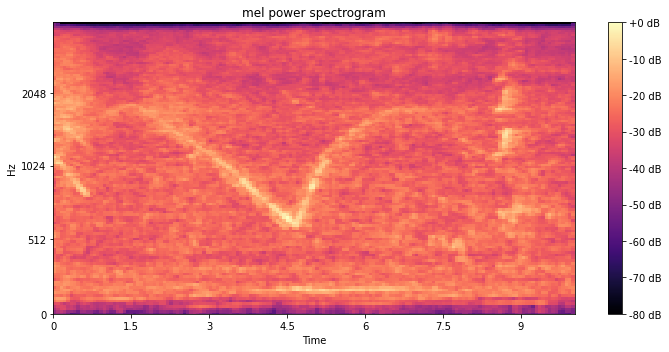

In [ ]:
plt.figure(figsize=(10,5))
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [ ]:
def mdf(y,sr,l,m=200,L=100):
    mdf = 0.0
    for n in range(m-L+1,m):
        mdf += abs(y[n] - y[n-l])
    return mdf

In [ ]:
def amdf(y,sr,tau,N):
    mdf = 0.0
    for n in range(N-1-tau):
        mdf += abs(y[n] - y[n+tau])
    mdf /= (N-1-tau)
    return mdf

In [ ]:
mdf_list = []
N = len(y[:513]) 
for i in range(0,512):
    mdf_list.append(mdf(y=y,sr=sr,l=i,m=N,L=512))

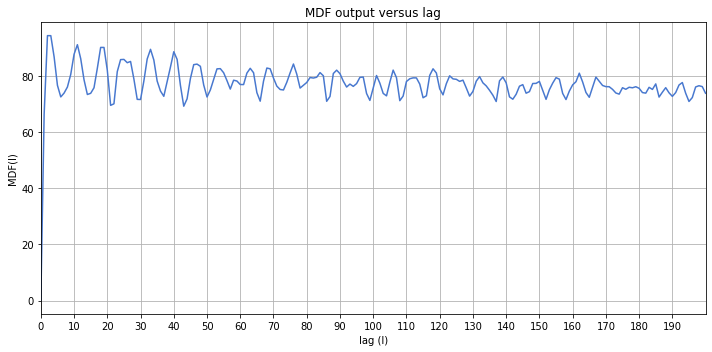

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mdf_list)
plt.title('MDF output versus lag')
plt.xlim([0,200])
plt.xlabel('lag (l)')
plt.ylabel('MDF(l)')
plt.grid('on')
plt.xticks(np.arange(0, 200, 10))
plt.tight_layout()

In [ ]:
amdf_list = []
N = len(y[:513])
start = time.time()
for i in range(512):
     amdf_list.append(amdf(y=y,sr=sr,tau=i,N=N))
end = time.time()
print("Execution time for AMDF is {} secs".format(round((end-start),4)))

Execution time for AMDF is 0.0719 secs


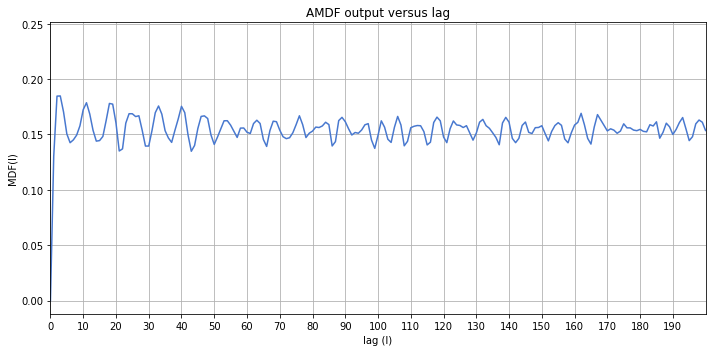

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(amdf_list)
plt.title('AMDF output versus lag')
plt.xlabel('lag (l)')
plt.xlim([0,200])
plt.ylabel('MDF(l)')
plt.grid('on')
plt.xticks(np.arange(0, 200, 10.0))
plt.tight_layout()

In [ ]:
def camdf(y,sr,tau,N):
    D = 0.0
    for n in range(N):
        D += abs(y[(n+tau)%N] - y[n])
    return D

In [ ]:
camdf_list = []
N = len(y[:513])
start = time.time()
for i in range(512):
     camdf_list.append(camdf(y=y,sr=sr,tau=i,N=N))
end = time.time()
print("Execution time for CAMDF is {} secs".format(round((end-start),4)))

Execution time for CAMDF is 0.1508 secs


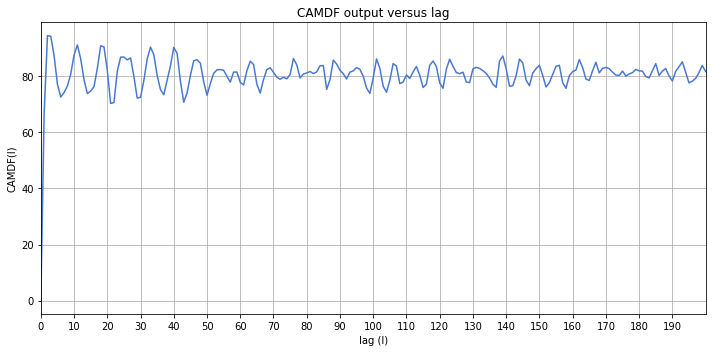

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(camdf_list)
plt.title('CAMDF output versus lag')
plt.xlabel('lag (l)')
plt.xlim([0,200])
plt.ylabel('CAMDF(l)')
plt.grid('on')
plt.xticks(np.arange(0, 200, 10.0))
plt.tight_layout()

In [ ]:
interval = amdf_list[4:100]
min_D = min(interval)
pitch_detected = round(sr/(interval.index(min_D)+4),2)
print("Detected Pitch: {} Hz".format(pitch_detected))

Detected Pitch: 186.05 Hz


In [ ]:
interval = camdf_list[4:100]
min_D = min(interval)
pitch_detected = round(sr/(interval.index(min_D)+4),2)
print("Detected Pitch: {} Hz".format(pitch_detected))

Detected Pitch: 380.95 Hz



Probability of the presence of a siren

In [ ]:
N = len(y[:513])
pitch_list = []
for i in range(30):
    camdf_list = []
    y_clip = y[256*i:256*i+512+1]
    for i in range(512):
        camdf_list.append(camdf(y=y_clip,sr=sr,tau=i,N=N))
    interval = camdf_list[4:100]
    min_D = min(interval)
    pitch_detected = round(sr/(interval.index(min_D)+4),2)
    pitch_list.append(pitch_detected)

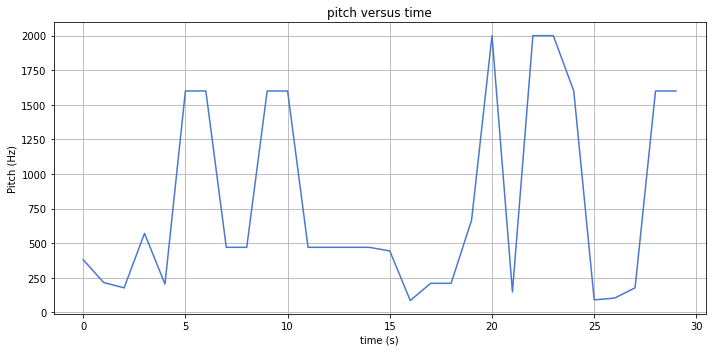

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(pitch_list)
plt.title('pitch versus time')
plt.xlabel('time (s)')
plt.ylabel('Pitch (Hz)')
plt.grid('on')
plt.tight_layout()